In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm

In [19]:
xlsx_file = "Dataset TD4.xlsx"  
csv_file = "Dataset TD4.csv"  


df = pd.read_excel(xlsx_file)


df.to_csv(csv_file, index=False, encoding='utf-8')

print(f"Le fichier {xlsx_file} a été converti en {csv_file}.")

Le fichier Dataset TD4.xlsx a été converti en Dataset TD4.csv.


In [13]:
csv_data = pd.read_csv("Dataset TD4.csv", delimiter=",")

In [4]:
volume = []
transaction_price = []
transaction_sign = []

In [15]:
print(csv_data.columns)


Index(['transaction date (1=1day=24 hours)', 'bid-ask spread',
       'volume of the transaction (if known)', 'Sign of the transaction',
       'Price (before transaction)'],
      dtype='object')


In [14]:
csv_data.head()

,transaction date (1=1day=24 hours),bid-ask spread,volume of the transaction (if known),Sign of the transaction,Price (before transaction)
0,0.000202,0.1100,8.0,-1,100.000
1,0.001070,0.1030,NaN,1,99.984
2,0.001496,0.1015,NaN,-1,100.029
3,0.003336,0.0920,NaN,1,99.979
4,0.003952,0.1106,NaN,1,100.060


In [16]:
for i in range(len(csv_data) - 1):  # Adjust to -1 to avoid index issues
    # Check if the 'volume of the transaction (if known)' is not NaN
    if pd.notna(csv_data['volume of the transaction (if known)'].iloc[i]):
        # Append the volume value to the list
        volume.append(csv_data['volume of the transaction (if known)'].iloc[i])
        
        # Extend the transaction_price list with current and next prices
        transaction_price.extend([
            csv_data['Price (before transaction)'].iloc[i],
            csv_data['Price (before transaction)'].iloc[i + 1]
        ])
        
        # Append the transaction sign to the list
        transaction_sign.append(csv_data['Sign of the transaction'].iloc[i])

In [20]:
# Returns
returns = [
    (transaction_price[i + 1] - transaction_price[i]) / transaction_price[i]
    for i in range(len(transaction_price) - 1)
]
returns = np.array(returns)

In [21]:
# sigma (standard deviation of returns) annualized
sigma = np.std(returns) * np.sqrt(24) * np.sqrt(252)  # 24 hours/day, 252 trading days/year
print("Sigma (annualized):", sigma)

Sigma (annualized): 0.10701027068624092


In [22]:
# total volume
total_volume = np.sum(volume)
print("Total Volume:", total_volume)

Total Volume: 14831.0


In [23]:
# Time interval (1 hour in a day)
time_interval = 1 / 24
print("Time Interval:", time_interval)

Time Interval: 0.041666666666666664


In [25]:
# price difference
price_difference = np.array([
    transaction_price[i + 1] - transaction_price[i]
    for i in range(0, len(transaction_price) - 1, 2)
])

In [26]:
# Signed volume
signed_volume = np.array([
    volume[i] * transaction_sign[i]
    for i in range(len(volume))
])

In [27]:
volume_squared_signed = np.array([
    transaction_sign[i] * volume[i] ** 2
    for i in range(len(price_difference))
])


In [28]:
# modified prices
modified_price_gamma = price_difference
modified_price_tha = -price_difference

In [29]:
# Reshape signed volume for compatibility
X_gamma_mod = signed_volume.reshape(-1, 1)

In [30]:
# Stack columns to create X_tha_mod
X_tha_mod = np.column_stack((signed_volume, volume_squared_signed))

In [32]:
def linear_regression_np(X, y):
    
    X_mean = np.mean(X)
    y_mean = np.mean(y)
    
    # Calculate the slope (m)
    slope = np.sum((X - X_mean) * (y - y_mean)) / np.sum((X - X_mean) ** 2)
    
    # Calculate the intercept (c)
    intercept = y_mean - slope * X_mean
    
    return slope, intercept

In [33]:
X_gamma_array = np.array(X_gamma_mod[:, 0])
prix_gamma_array = np.array(modified_price_gamma)

slope_gamma, intercept_gamma = linear_regression_np(X_gamma_array, prix_gamma_array)


y_pred_gamma = slope_gamma * X_gamma_array + intercept_gamma

# MSE
mse_gamma = np.mean((prix_gamma_array - y_pred_gamma) ** 2)

# R^2 score
r2_gamma = 1 - (np.sum((prix_gamma_array - y_pred_gamma) ** 2) / 
                np.sum((prix_gamma_array - np.mean(prix_gamma_array)) ** 2))

In [34]:
# Print regression results
print(f"\nEstimation gamma: {slope_gamma}")
print(f"MSE: {mse_gamma}; R^2: {r2_gamma}")


Estimation gamma: 0.0005023780590409201
MSE: 0.0004907505222142957; R^2: 0.9193112589657633


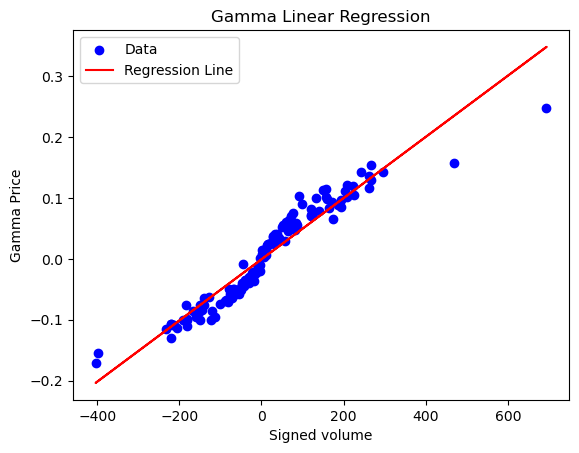

In [39]:
# Plot 
plt.scatter(X_gamma_array, prix_gamma_array, color="blue", label="Data")
plt.plot(X_gamma_array, y_pred_gamma, color="red", label="Regression Line")
plt.xlabel("Signed volume")
plt.ylabel("Gamma Price")
plt.title("Gamma Linear Regression")
plt.legend()
plt.show()

In [40]:
def linear_regression_multivariate(X, y):
    X_mean = np.mean(X, axis=0)
    y_mean = np.mean(y)
    
    X_cov = np.dot(X.T, X) - np.sum(X, axis=0) * X_mean
    
    # Compute the inverse of the covariance matrix
    X_cov_inv = np.linalg.inv(X_cov)
    
    # Calculate the covariance between X and y
    X_X_mean_y_mean = np.dot(X.T, y) - np.sum(X, axis=0) * y_mean
    
    # Calculate coefficients (slopes)
    coefficients = np.dot(X_cov_inv, X_X_mean_y_mean)
    
    # Calculate the intercept
    intercept = y_mean - np.dot(coefficients.T, X_mean)
    
    return coefficients, intercept


In [41]:
X_tha_array = np.column_stack((X_gamma_mod, volume_squared_signed))
prix_tha_array = np.array(modified_price_tha)

In [42]:
coefficients_tha, intercept_tha = linear_regression_multivariate(X_tha_array, prix_tha_array)

In [43]:
y_pred_tha = np.dot(X_tha_array, coefficients_tha) + intercept_tha

In [44]:
# Calculating the Mean Squared Error (MSE) and R-squared (R²)
mse_tha = np.mean((prix_tha_array - y_pred_tha) ** 2)
r2_tha = 1 - sum((prix_tha_array - y_pred_tha) ** 2) / sum(
    (prix_tha_array - np.mean(prix_tha_array)) ** 2
)

In [46]:
# Calculating the theta coefficient
tau = time_interval
tha = coefficients_tha[1] * tau  # Etha is the second coefficient

In [47]:
print(f"\nEstimation tha: {tha}")
print(f"MSE: {mse_tha}; R²: {r2_tha}")


Estimation tha: 2.501334212024121e-09
MSE: 0.000524208126118681; R²: 0.9138101910812381


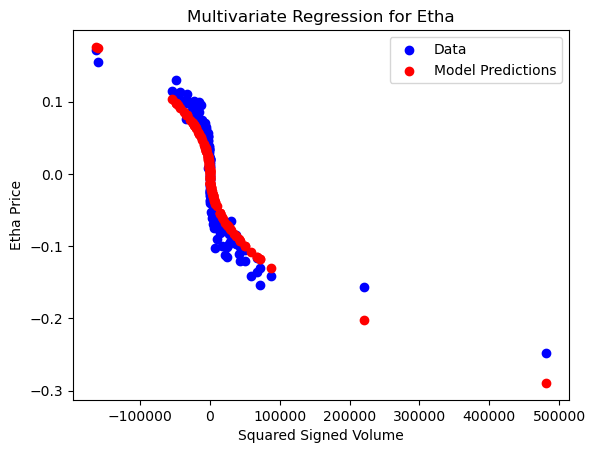

In [49]:
plt.scatter(volume_squared_signed, prix_tha_array, color="blue", label="Data")
plt.scatter(volume_squared_signed, y_pred_tha, color="red", label="Model Predictions")
plt.xlabel("Squared Signed Volume")
plt.ylabel("Etha Price")
plt.title("Multivariate Regression for Etha")
plt.legend()
plt.show()


In [50]:
X = 1000000  # Initial number of actions
T = [(1 / 24) * i for i in range(1, 25)]  # Time intervals in days
Lambda_values = [1e-5, 1e-4, 1e-3]  # Different values of Lambda

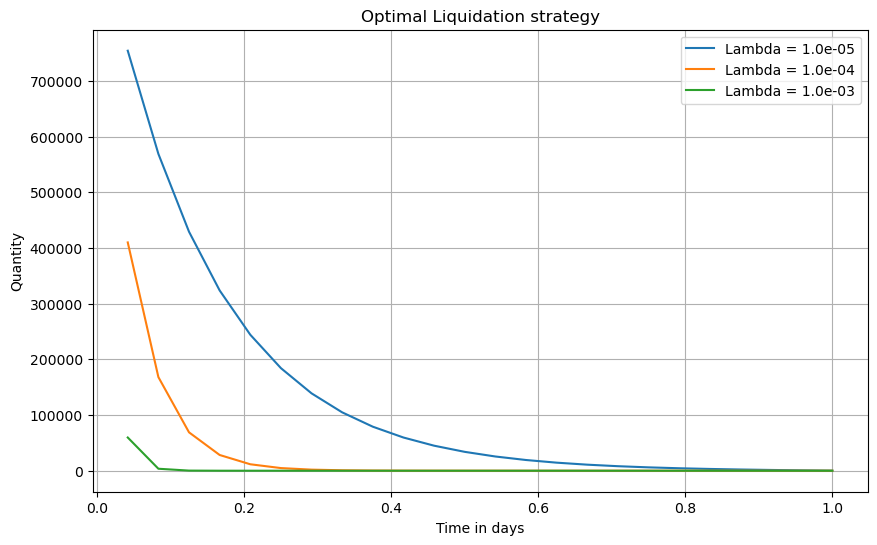

In [55]:
plt.figure(figsize=(10, 6))

for Lambda in Lambda_values:
    K = np.sqrt(Lambda * (sigma**2) / tha)  # Calculate K
    strat = [np.sinh(K * (1 - t)) * X / np.sinh(K * 1) for t in T]  # Strategy
    plt.plot(T, strat, label=f'Lambda = {Lambda:.1e}')

plt.title("Optimal Liquidation strategy")
plt.xlabel("Time in days")
plt.ylabel("Quantity")
plt.legend()
plt.grid(True)
plt.show()